In [1]:
import pickle
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
from keras.callbacks import LearningRateScheduler
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
tf.compat.v1.Session(config=config).close()

2024-11-02 16:43:08.652764: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

from keras.layers import BatchNormalization, LeakyReLU, MaxPooling1D, Dropout, Flatten, Dense, Conv1D,Reshape,multiply,GlobalAveragePooling1D
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from keras.regularizers import l2
from scipy.interpolate import splev, splrep
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
base_dir = "./dataset"
ir = 3 
before = 2
after = 2

scaler = lambda arr: (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

In [4]:
from scipy.interpolate import CubicSpline
def interpolate_numpy_array(arr, desired_length):
    cs = CubicSpline(np.linspace(0, 1, len(arr)), arr)
    x_new = np.linspace(0, 1, desired_length)
    interpolated_arr = cs(x_new)
    return interpolated_arr

In [5]:
import random
def load_data():
    tm = np.arange(0, (before + 1 + after) * 60, step=1 / float(ir))
    with open(os.path.join(base_dir, "apnea.pkl"), 'rb') as f:
        apnea_ecg = pickle.load(f)
    x_train1,x_train2,x_train3 = [],[],[]
    o_train, y_train = apnea_ecg["o_train"], apnea_ecg["y_train"]
    groups_train = apnea_ecg["groups_train"]
    for i in range(len(o_train)):
        min_distance_list, max_distance_list= o_train[i]
        min_distance_list_inter = interpolate_numpy_array(min_distance_list,900)
        max_distance_list_inter = interpolate_numpy_array(max_distance_list,900)
        x_train1.append([min_distance_list_inter, max_distance_list_inter])
        x_train2.append([min_distance_list_inter[180:720], max_distance_list_inter[180:720]])
        x_train3.append([min_distance_list_inter[360:540], max_distance_list_inter[360:540]])
    x_training1,x_training2,x_training3,y_training,groups_training = [],[],[],[],[]
    x_val1,x_val2,x_val3,y_val,groups_val = [],[],[],[],[]

    trainlist = random.sample(range(len(o_train)),int(len(o_train)*0.7))
    num=[i for i in range(16713)]
    vallist = set(num) - set(trainlist)
    vallist = list(vallist)
    for i in trainlist:
        x_training1.append(x_train1[i])
        x_training2.append(x_train2[i])
        x_training3.append(x_train3[i])
        y_training.append(y_train[i])
        groups_training.append(groups_train[i])
    for i in vallist:
        x_val1.append(x_train1[i])
        x_val2.append(x_train2[i])
        x_val3.append(x_train3[i])
        y_val.append(y_train[i])
        groups_val.append(groups_train[i])

    x_training1 = np.array(x_training1, dtype="float32").transpose((0, 2, 1))
    x_training2 = np.array(x_training2, dtype="float32").transpose((0, 2, 1))
    x_training3 = np.array(x_training3, dtype="float32").transpose((0, 2, 1))
    y_training = np.array(y_training, dtype="float32")
    x_val1 = np.array(x_val1, dtype="float32").transpose((0, 2, 1))
    x_val2 = np.array(x_val2, dtype="float32").transpose((0, 2, 1))
    x_val3 = np.array(x_val3, dtype="float32").transpose((0, 2, 1))
    y_val = np.array(y_val, dtype="float32")

    x_test1,x_test2,x_test3 = [],[],[]
    o_test, y_test = apnea_ecg["o_test"], apnea_ecg["y_test"]
    groups_test = apnea_ecg["groups_test"]
    for i in range(len(o_test)):
        min_distance_list, max_distance_list = o_test[i]
        min_distance_list_inter = interpolate_numpy_array(min_distance_list,900)
        max_distance_list_inter = interpolate_numpy_array(max_distance_list,900)
        x_test1.append([min_distance_list_inter, max_distance_list_inter])
        x_test2.append([min_distance_list_inter[180:720], max_distance_list_inter[180:720]])
        x_test3.append([min_distance_list_inter[360:540], max_distance_list_inter[360:540]])
    x_test1 = np.array(x_test1, dtype="float32").transpose((0, 2, 1))
    x_test2 = np.array(x_test2, dtype="float32").transpose((0, 2, 1))
    x_test3 = np.array(x_test3, dtype="float32").transpose((0, 2, 1))
    y_test = np.array(y_test, dtype="float32")

    return x_training1, x_training2, x_training3, y_training, groups_training, x_val1, x_val2, x_val3, y_val, groups_val, x_test1, x_test2, x_test3, y_test, groups_test

In [6]:
class ChannelAttention(tf.keras.layers.Layer):
    def __init__(self, ratio=4,**kwargs):
        super(ChannelAttention, self).__init__()
        self.ratio = ratio

    def build(self, input_shape):
        self.channels = input_shape[-1]
        self.fc1 = tf.keras.layers.Dense(self.channels // self.ratio, activation='relu')
        self.fc2 = tf.keras.layers.Dense(self.channels, activation='sigmoid')

    def call(self, inputs):
        max_pool = tf.reduce_max(inputs, axis=[1, 2], keepdims=True)
        avg_pool = tf.reduce_mean(inputs, axis=[1, 2], keepdims=True)
        max_pool = self.fc1(max_pool)
        avg_pool = self.fc1(avg_pool)
        attention = self.fc2(tf.keras.layers.add([max_pool, avg_pool]))
        return inputs * attention


In [7]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res


In [8]:
class ResidualAttentionBlock(tf.keras.layers.Layer):
    def __init__(self, num_input_features, num_output_features):
        super(ResidualAttentionBlock, self).__init__()
        self.conv1 = tf.keras.layers.Conv1D(num_output_features, kernel_size=1, strides=1, padding='valid', use_bias=False)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv1D(num_output_features, kernel_size=3, strides=1, padding='same', use_bias=False)
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.conv3 = tf.keras.layers.Conv1D(num_output_features, kernel_size=1, strides=1, padding='valid', use_bias=False)
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.sigmoid = tf.keras.layers.Activation('sigmoid')

    def call(self, x):
        residual = x       

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out = self.sigmoid(out)      

        out = out * residual + residual

        return out


In [14]:
from keras.layers import AveragePooling1D
from tensorflow.keras.layers import Input, BatchNormalization, GRU, Dropout
from tensorflow.keras.regularizers import l2


def create_model(input_a_shape, input_b_shape, input_c_shape, weight=1e-3,rate=1):
    leaky_relu = LeakyReLU()

    # CNN-1
    input1 = Input(shape=input_a_shape)

    x1 = BatchNormalization()(input1)    
    x1 = Conv1D(96, kernel_size=11, strides=4, padding="same", kernel_initializer="he_normal",
               kernel_regularizer=l2(weight), bias_regularizer=l2(weight))(x1)   
    x1 = leaky_relu(x1)
    x1 = MaxPooling1D(pool_size=3, padding="same")(x1)
    x1 = Dropout(0.5)(x1)

    x1 = Conv1D(256, kernel_size=7, strides=1, padding="same", kernel_initializer="he_normal",
               kernel_regularizer=l2(weight), bias_regularizer=l2(weight))(x1)
    x1 = BatchNormalization()(x1)
    x1 = leaky_relu(x1)
    x1 = MaxPooling1D(pool_size=3,strides=2, padding="same")(x1)
    x1 = Dropout(0.5)(x1)

    x1 = Conv1D(384, kernel_size=5, strides=1, padding="same", kernel_initializer="he_normal",
               kernel_regularizer=l2(weight), bias_regularizer=l2(weight))(x1)
    x1 = BatchNormalization()(x1)
    x1 = leaky_relu(x1)
    x1 = MaxPooling1D(pool_size=2, padding="same")(x1)
    x1 = Dropout(0.5)(x1)

    x1 = Conv1D(384, kernel_size=3, strides=1, padding="same", kernel_initializer="he_normal",
               kernel_regularizer=l2(weight), bias_regularizer=l2(weight))(x1)
    x1 = BatchNormalization()(x1)
    x1 = leaky_relu(x1)
    x1 = MaxPooling1D(pool_size=2, padding="same")(x1)
    x1 = Dropout(0.5)(x1)

    x1 = Conv1D(256, kernel_size=3, strides=1, padding="same", kernel_initializer="he_normal",
               kernel_regularizer=l2(weight), bias_regularizer=l2(weight))(x1)
    x1 = BatchNormalization()(x1)
    x1 = leaky_relu(x1)   
    x1 = MaxPooling1D(pool_size=2, padding="same")(x1)
    x1 = Dropout(0.5)(x1)
    
    # CNN-2
    input2 = Input(shape=input_b_shape)
    x2 = BatchNormalization()(input2)

    x2 = Conv1D(16, kernel_size=9, strides=4, padding="same", kernel_initializer="he_normal",
               kernel_regularizer=l2(weight), bias_regularizer=l2(weight))(x2)
    
    x2 = leaky_relu(x2)
    x2 = MaxPooling1D(pool_size=3)(x2)
    x2 = Dropout(0.5)(x2)

    x2 = Conv1D(32, kernel_size=5, strides=1, padding="same", kernel_initializer="he_normal",
               kernel_regularizer=l2(weight), bias_regularizer=l2(weight))(x2)
    x2 = BatchNormalization()(x2)
    x2 = leaky_relu(x2)
    x2 = MaxPooling1D(pool_size=3)(x2)
    x2 = Dropout(0.5)(x2)

    x2 = Conv1D(64, kernel_size=3, strides=1, padding="same", kernel_initializer="he_normal",
               kernel_regularizer=l2(weight), bias_regularizer=l2(weight))(x2)
    x2 = BatchNormalization()(x2)
    x2 = leaky_relu(x2)
    x2 = Dropout(0.5)(x2)

    x2 = Conv1D(128, kernel_size=3, strides=1, padding="same", kernel_initializer="he_normal",
               kernel_regularizer=l2(weight), bias_regularizer=l2(weight))(x2)
    x2 = BatchNormalization()(x2)
    x2 = leaky_relu(x2)
    x2 = Dropout(0.5)(x2)

    x2 = Conv1D(256, kernel_size=3, strides=1, padding="same", kernel_initializer="he_normal",
               kernel_regularizer=l2(weight), bias_regularizer=l2(weight))(x2)
    x2 = BatchNormalization()(x2)
    x2 = leaky_relu(x2)   
    x2 = MaxPooling1D(pool_size=3)(x2)    
    x2 = Dropout(0.5)(x2)


    # CNN-3
    input3 = Input(shape=input_c_shape)
   
    x3 = Conv1D(16, kernel_size=7, strides=4, padding="same", kernel_initializer="he_normal",
               kernel_regularizer=l2(weight), bias_regularizer=l2(weight))(input3)
    x3 = BatchNormalization()(x3)
    x3 = leaky_relu(x3)
    x3 = MaxPooling1D(pool_size=3)(x3)
    x3 = Dropout(0.5)(x3)

    x3 = Conv1D(32, kernel_size=3, strides=1, padding="same", kernel_initializer="he_normal",
               kernel_regularizer=l2(weight), bias_regularizer=l2(weight))(x3)
    x3 = BatchNormalization()(x3)
    x3 = leaky_relu(x3)
    x3 = MaxPooling1D(pool_size=3)(x3)
    x3 = Dropout(0.5)(x3)

    x3 = Conv1D(64, kernel_size=3, strides=1, padding="same", kernel_initializer="he_normal",
               kernel_regularizer=l2(weight), bias_regularizer=l2(weight))(x3)
    x3 = BatchNormalization()(x3)
    x3 = leaky_relu(x3)
    x3 = Dropout(0.5)(x3)

    attention1 = ResidualAttentionBlock(256, 256)
    attention2 = ResidualAttentionBlock(64, 64)
    x1 = attention1(x1)
    x2 = attention1(x2)
    x3 = attention2(x3)
  
    concat = keras.layers.concatenate([x1, x2, x3], name="Concat_Layer", axis=-1)  
    concat=ChannelAttention()(concat)
    x = GlobalAveragePooling1D()(concat)
    dp = Dropout(0.5)(x)
    outputs = Dense(2, activation='softmax', name="Output_Layer")(dp)
    model = Model(inputs=[input1, input2, input3], outputs=outputs)
    return model

In [15]:
def lr_schedule(epoch, lr):
    if epoch > 70 and \
            (epoch - 1) % 10 == 0:
        lr *= 0.1
    print("Learning rate: ", lr)
    return lr

In [16]:
def plot(history):
    """Plot performance curve"""
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].plot(history["loss"], "r-", history["val_loss"], "b-", linewidth=0.5)
    axes[0].set_title("Loss")
    axes[1].plot(history["accuracy"], "r-", history["val_accuracy"], "b-", linewidth=0.5)
    axes[1].set_title("Accuracy")
    fig.tight_layout()
    plt.show()

In [17]:
from keras import optimizers
if __name__ == "__main__":

    x_train1, x_train2, x_train3, y_train, groups_train, x_val1, x_val2, x_val3, y_val, groups_val, x_test1, x_test2, x_test3, y_test, groups_test= load_data()

    y_train = keras.utils.to_categorical(y_train, num_classes=2)  # Convert to two categories
    y_val = keras.utils.to_categorical(y_val, num_classes=2)
    y_test = keras.utils.to_categorical(y_test, num_classes=2)

    print('input_shape', x_train1.shape, x_train2.shape, x_train3.shape)

input_shape (11699, 900, 2) (11699, 540, 2) (11699, 180, 2)


Learning rate:  0.0010000000474974513
Epoch 1/100
92/92 [==============================] - 25s 51ms/step - loss: 4.2079 - accuracy: 0.6489 - val_loss: 4.3095 - val_accuracy: 0.4059 - lr: 0.0010
Learning rate:  0.0010000000474974513
Epoch 2/100
92/92 [==============================] - 3s 32ms/step - loss: 2.9567 - accuracy: 0.8127 - val_loss: 2.7727 - val_accuracy: 0.5560 - lr: 0.0010
Learning rate:  0.0010000000474974513
Epoch 3/100
92/92 [==============================] - 3s 33ms/step - loss: 2.1068 - accuracy: 0.8358 - val_loss: 1.7945 - val_accuracy: 0.8444 - lr: 0.0010
Learning rate:  0.0010000000474974513
Epoch 4/100
92/92 [==============================] - 3s 34ms/step - loss: 1.5057 - accuracy: 0.8601 - val_loss: 1.2734 - val_accuracy: 0.8696 - lr: 0.0010
Learning rate:  0.0010000000474974513
Epoch 5/100
92/92 [==============================] - 3s 34ms/step - loss: 1.1357 - accuracy: 0.8708 - val_loss: 0.9876 - val_accuracy: 0.8761 - lr: 0.0010
Learning rate:  0.0010000000474974

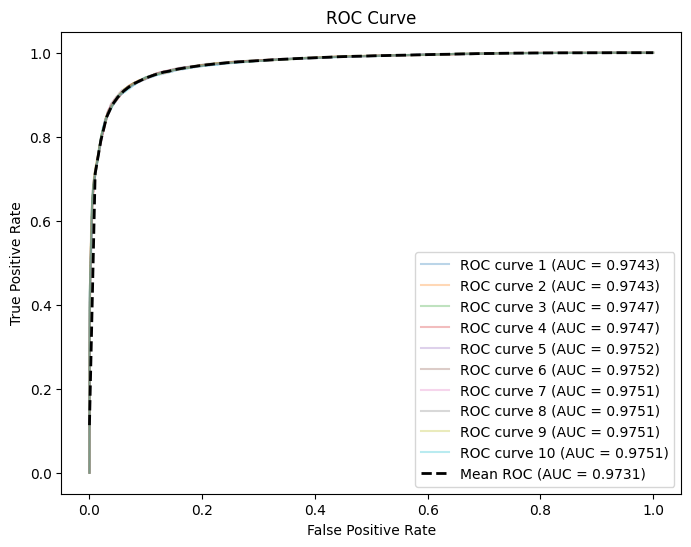

In [18]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
import numpy as np
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, f1_score,roc_auc_score
losses = []
accuracies = []
sensitivities = []
specificities = []
f1_scores = []
auc_scores = []
fprs = []
tprs = []

num_trainings = 10
for i in range(num_trainings):
    model = create_model(x_train1.shape[1:], x_train2.shape[1:], x_train3.shape[1:])
    model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])
    lr_scheduler = LearningRateScheduler(lr_schedule)
    history = model.fit([x_train1, x_train2, x_train3], y_train, batch_size=128, epochs=100,
                        validation_data=([x_val1, x_val2, x_val3], y_val), callbacks=[lr_scheduler])
    loss, accuracy = model.evaluate([x_test1, x_test2, x_test3], y_test)
    y_prob = model.predict([x_test1, x_test2, x_test3], batch_size=1024, verbose=1)

    y_true = y_test.argmax(axis=-1)
    y_pred = np.argmax(y_prob, axis=-1)

    C = confusion_matrix(y_true, y_pred, labels=(1, 0))
    TP, TN, FP, FN = C[0, 0], C[1, 1], C[1, 0], C[0, 1]
    acc, sn, sp = 1. * (TP + TN) / (TP + TN + FP + FN), 1. * TP / (TP + FN), 1. * TN / (TN + FP)
    acc = accuracy_score(y_true, y_pred)
    sn = TP / (TP + FN)  
    sp = TN / (TN + FP) 
    precision = TP / (TP + FP)
    recall = sn
    f1 = 2 * (precision * recall) / (precision + recall)

    fpr, tpr, _ = roc_curve(y_true, y_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    fprs.append(fpr)
    tprs.append(tpr)
    auc_scores.append(roc_auc)
    
    print("TP:{}, TN:{}, FP:{}, FN:{}, loss{}, acc{}, sn{}, sp{}, f1{}, auc{}".format(TP, TN, FP, FN, loss, acc, sn, sp, f1, roc_auc))
    losses.append(loss)
    accuracies.append(acc)
    sensitivities.append(sn)
    specificities.append(sp)
    f1_scores.append(f1)
    auc_scores.append(roc_auc)

avg_loss = np.mean(losses)
avg_accuracy = np.mean(accuracies)
avg_sensitivity = np.mean(sensitivities)
avg_specificity = np.mean(specificities)
avg_f1_score = np.mean(f1_scores)
avg_auc_score = np.mean(auc_scores)

print("Average Test loss: ", avg_loss)
print("Average Accuracy: ", avg_accuracy)
print("Average Sensitivity: ", avg_sensitivity)
print("Average Specificity: ", avg_specificity)
print("Average F1 Score: ", avg_f1_score)
print("Average AUC Score: ", avg_auc_score)

plt.figure(figsize=(8, 6))
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.zeros_like(mean_fpr)
for i in range(num_trainings):
    mean_tpr += np.interp(mean_fpr, fprs[i], tprs[i])
    plt.plot(fprs[i], tprs[i], alpha=0.3, label='ROC curve {} (AUC = {:.4f})'.format(i+1, auc_scores[i]))
    print('AUC for ROC curve {}: {:.4f}'.format(i+1, auc_scores[i]))
mean_tpr /= num_trainings
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', label='Mean ROC (AUC = {:.4f})'.format(mean_auc), lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()
